In [17]:
import pandas as pd
import numpy as np
import math
import pickle

from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
from scipy.io import loadmat

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from src import SMOTE
from src import CFS
from src import metrices_V2 as metrices

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib.pyplot as plt

# Data Load and other util function

In [2]:
def load_data(project):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
#     print(cols_list)
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    cols = understand_df.columns.tolist()

#     understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    df = understand_df
    for item in ['Kind','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
    df.dropna(inplace=True)
    return df

def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def apply_cfs(df):
        y = df.Bugs.values
        X = df.drop(labels = ['Bugs'],axis = 1)
        X = X.values
        selected_cols = CFS.cfs(X,y)
        cols = df.columns[[selected_cols]].tolist()
        cols.append('Bugs')
        return df[cols],cols

def get_spearmanr(df):
    df = df.drop('Bugs',axis = 1)
    file_corr = []
    for name in df.Name.unique():
        sub_df = df[df['Name'] == name]
        if sub_df.shape[0] < 2:
            continue
        sub_df = sub_df.drop('Name',axis = 1)
        rho, pval = stats.spearmanr(sub_df.values,sub_df.values,axis = 1)
        file_corr.append(np.median(rho[:,:int(len(rho)/2)]))
    return file_corr

# Getting List of projects

In [3]:
proj_df = pd.read_csv('projects.csv')
projects = proj_df.repo_name.tolist()

# Run the experiment

In [4]:
project_corr = {}
for project in projects:
    try:
        if project == '.DS_Store':
            continue
#         if project != 'Pokemap':
#             continue
        print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
        df = load_data(project)
        corr = get_spearmanr(df)
        project_corr[project] = corr
        print(np.median(corr))
    except Exception as e:
        print(e)
        continue
with open('results/Performance/product_corr.pkl', 'wb') as handle:
    pickle.dump(project_corr, handle, protocol=pickle.HIGHEST_PROTOCOL)

+++++++++++++++++   org.alloytools.alloy  +++++++++++++++++
0.9952894018179659
+++++++++++++++++   qpython  +++++++++++++++++
1.0
+++++++++++++++++   friendlychat-android  +++++++++++++++++
0.9722682462009827
+++++++++++++++++   paho.mqtt.android  +++++++++++++++++
1.0
+++++++++++++++++   paho.mqtt.java  +++++++++++++++++
1.0
+++++++++++++++++   android-docs-samples  +++++++++++++++++
1.0
+++++++++++++++++   Toasty  +++++++++++++++++
0.9999999999999999
+++++++++++++++++   android-mvvm-architecture  +++++++++++++++++
1.0
+++++++++++++++++   recipes-rss  +++++++++++++++++
1.0
+++++++++++++++++   HoloGraphLibrary  +++++++++++++++++
1.0


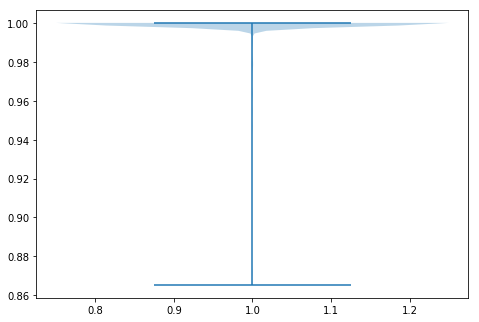

In [16]:
# flat_list = [item for sublist in list(project_corr.values()) for item in sublist]
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# bp = ax.violinplot(flat_list)